In [1]:
%matplotlib inline

In [2]:
sc

In [3]:
rdd = sc.parallelize(range(1000), 20)

In [4]:
rdd.getNumPartitions()

20

In [5]:
from pyspark.mllib.util import MLUtils
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint


In [6]:
from sklearn.metrics import average_precision_score

50000 training segments....

25k virus

25k non-virus


In [7]:
def evaluate_model(testing, model):
    model.clearThreshold()
    labelsAndScores = testing.map(lambda p: (p.label, model.predict(p.features)))
    LS = labelsAndScores.collect()
    y_true = []
    y_scores = []
    for s in LS:
        y_true.append(s[0])
        y_scores.append(s[1])
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    au_PRC = average_precision_score(y_true, y_scores)
    return au_PRC, precision, recall, thresholds

In [8]:
def testing_model(testing, model):
    # not useful any more... use evaluate_model instead
    labelsAndPreds = testing.map(lambda p: (p.label, model.predict(p.features)))
    Err = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(testing.count())
    
    LP = labelsAndPreds.collect()
    
    label_list = []
    prediction = []
    for t in LP:
        label_list.append(t[0])
        prediction.append(t[1])
    matrix = confusion_matrix(label_list, prediction)
    model.clearThreshold()
    labelsAndScores = testing.map(lambda p: (p.label, model.predict(p.features)))
    labelsAndScores_list = labelsAndScores.collect()

    y_true = []
    y_scores = []
    for t in LP:
        y_true.append(t[0])
        y_scores.append(t[1])
        
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    return [Err, matrix, precision, recall]


# define working directory with data for model tuning here

In [9]:
tuning_work_directory = '/Users/qingpeng/Local/GeneLearn'

## Standard, family level, logistic regression, all features


In [10]:
training = MLUtils.loadLibSVMFile(sc, tuning_work_directory+"/training.vect")
training.cache()
testing = MLUtils.loadLibSVMFile(sc, tuning_work_directory+"/testing.vect",19421)
testing.cache()

PythonRDD[8] at RDD at PythonRDD.scala:48

In [11]:
model_logistic = LogisticRegressionWithLBFGS.train(training)
model_logistic.clearThreshold()
labelsAndScores = testing.map(lambda p: (p.label, model_logistic.predict(p.features)))

In [12]:
LS = labelsAndScores.collect()


score_virus = []
score_nonvirus = []
for s in LS:
    if s[0] == 0.0:
        score_nonvirus.append(s[1])
    else:
        score_virus.append(s[1])
    
    

In [13]:
result = evaluate_model(testing, model_logistic)

In [14]:
result

(0.9420192274262057,
 array([ 0.5       ,  0.69548387,  0.69936435, ...,  0.95063215,
         0.95048309,  1.        ]),
 array([ 1.    ,  0.9702,  0.9682, ...,  0.3158,  0.3148,  0.    ]),
 array([  9.02813412e-176,   3.14477912e-007,   4.57338217e-007, ...,
          9.99999561e-001,   9.99999585e-001,   9.99999624e-001]))

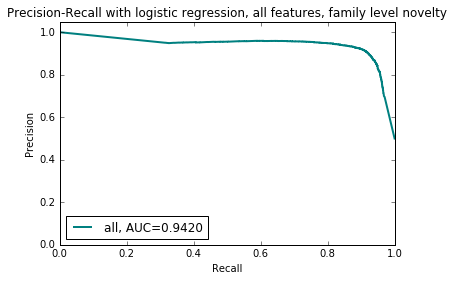

In [15]:
lw = 2
plt.figure(figsize=(6, 4), dpi=80)

# Plot Precision-Recall curve
plt.clf()

plt.plot(result[2], result[1], lw=lw, color='teal',
         label='all, AUC={0:0.4f}'.format(result[0]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with logistic regression, all features, family level novelty')
plt.legend(loc="lower left")
plt.show()


## Testing different algorithms

In [17]:
model_logistic_L1 = LogisticRegressionWithLBFGS.train(training,regType='l1')



Py4JJavaError: An error occurred while calling o130.trainLogisticRegressionModelWithLBFGS.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 234.0 failed 1 times, most recent failure: Lost task 0.0 in stage 234.0 (TID 1382, localhost): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1454)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1442)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1441)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1441)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1667)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1622)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1611)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1873)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1936)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1002)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:358)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:984)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1127)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:358)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1104)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:287)
	at org.apache.spark.mllib.classification.LogisticRegressionWithLBFGS.runWithMlLogisticRegression$1(LogisticRegression.scala:445)
	at org.apache.spark.mllib.classification.LogisticRegressionWithLBFGS.run(LogisticRegression.scala:452)
	at org.apache.spark.mllib.classification.LogisticRegressionWithLBFGS.run(LogisticRegression.scala:418)
	at org.apache.spark.mllib.classification.LogisticRegressionWithLBFGS.run(LogisticRegression.scala:348)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainRegressionModel(PythonMLLibAPI.scala:92)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainLogisticRegressionModelWithLBFGS(PythonMLLibAPI.scala:308)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


In [32]:
logistic_L1_result = evaluate_model(testing,model_logistic_L1 )

NameError: name 'logistic_L1_result' is not defined

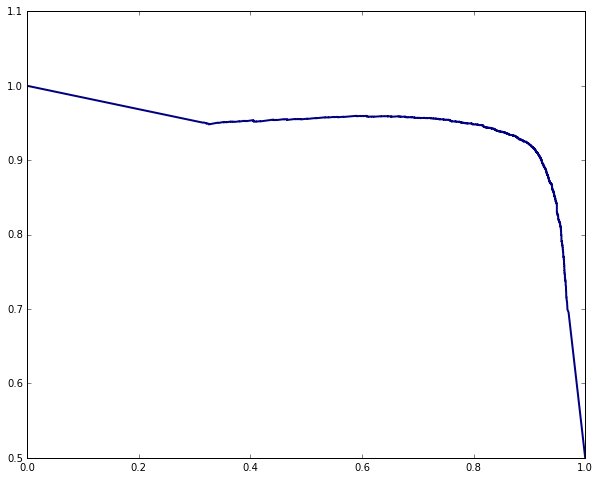

In [16]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result[2], result[1], lw=lw, color='navy',
         label='logistic L2, AUC={0:0.4f}'.format(result[0]))
plt.plot(logistic_L1_result[2], logistic_L1_result[1], lw=lw, color='turquoise',
         label='logistic L1, AUC={0:0.4f}'.format(logistic_L1_result[0]))



plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with logistic and SVM')
plt.legend(loc="lower left")
plt.show()
